In [1]:
import pandas as pd
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
import sys
from operator import add
from torch.nn import functional as F
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [10]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [11]:
seed_everything(seed=20)
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4,5,6,7]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["temperature"]
resample_method = "mean"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
scaled_data, scalers = data_scaling(resample, feature)

In [12]:
def distribution(datadict, feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [13]:
def delete_zone(datadict,zone_to_delete):
    for zone in zone_to_delete:
        if zone in datadict.keys():
            del datadict[zone]
    return datadict

In [14]:
def plot_data(datadict, cutting_date, feature):
    zone_list = sorted(list(datadict.keys()))
    for zone in zone_list:
        plt.figure(figsize=(20,3))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature],label=zone)
        plt.legend()
        plt.show()

In [15]:
new_scaled = delete_zone(scaled_data,  ["Floor5Z1","Floor5Z4","Floor7Z1"])

In [16]:
get_info_zone(new_scaled)

Floor4Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor7Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616



In [17]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            arraydata = datadict[floor].loc[date][features]
            databyDate[date][floor] = np.asarray(arraydata)#np.asarray(datadict[floor].loc[date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False, noise=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ

In [18]:
train_date, test_date = splitDate(remain_date, cutting_date)
databyDate = createDataByDate(new_scaled, feature,remain_date)

In [19]:
lookback = 13
lookahead = 1
batch_size = 32

In [20]:
def get_loader(floor_list,datadates, train_date, test_date, lookback, lookahead, batch_size):
    trainloader, testloader = [], []
    nb_zone = 5#*len(floor_list)
    zones = [i for i in range(1,nb_zone+1) if i!=3]
    zones_id = list(datadates[train_date[0]].keys())
    #for floor in floor_list:
    #    for zone in zones:
    #        zoneID = f'Floor{floor}Z{zone}'
    #        zones_id.append(zoneID)
    #random.shuffle(zones_id)
    for zone in zones_id:#range(1,nb_zone+1):
            print(f'-----{zone}-----')
            loaderZtrain = LoaderByZone(datadates,zone,train_date,lookback,lookahead,batch_size, shuffle=True)
            loaderZtest = LoaderByZone(datadates,zone,test_date,lookback, lookahead,batch_size, shuffle=False)
            trainloader.append(loaderZtrain)
            testloader.append(loaderZtest)
            #zones_id.append(zoneID)
    return trainloader, testloader, zones_id

In [21]:
trainloader, testloader, zone_id = get_loader(floors, databyDate, train_date, test_date, lookback, lookahead, batch_size)

-----Floor4Z5-----
-----Floor4Z4-----
-----Floor4Z2-----
-----Floor4Z1-----
-----Floor5Z5-----
-----Floor5Z2-----
-----Floor6Z4-----
-----Floor6Z5-----
-----Floor6Z1-----
-----Floor6Z2-----
-----Floor7Z4-----
-----Floor7Z5-----
-----Floor7Z2-----


In [22]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

360

# Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.hidden_size1,
                               num_layers=self.num_layers, batch_first=True)
        self.encoder2 = nn.LSTM(self.hidden_size1, self.hidden_size2, num_layers=1, batch_first=True)
        
        self.batch = nn.BatchNorm1d(self.hidden_size2)
    
        self.linear2 = nn.Linear(self.hidden_size2, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en) = self.encoder(x)
        out_en, (h_en) = self.encoder2(out_en)
        out_en = out_en[:,-1,:]
        out_en = self.batch(out_en)
        out = nn.LeakyReLU()(out_en)
        out = self.linear2(out)
        return out

In [24]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v

In [25]:
model = LSTM(1,64,64,lookback,lookahead)
optimm = OFW(model.parameters(), 1,0.95,1)

loaderz = []
prev_data = {}
#date = "2019-03-07"
t = 0
for date in train_date[:5]:
    for i in range(len(trainloader)):
        loaderz.append(trainloader[i][date])
    for couples in zip(*loaderz):
        eta = 1/(t+1)**(0.95)
        #print(couples[0][1].shape, couples[1][0].shape)
        all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
        all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
        prev_data[t] = (all_data_x, all_data_y)
        grad_sum = [torch.zeros_like(weight.data) for weight in model.parameters()]
        for ts in range(t+1):
            print(ts)
            with torch.enable_grad():
                model.zero_grad(set_to_none=True)
                x,y = prev_data[ts][0], prev_data[ts][1]
                out = model(x)
                loss = loss_fn(out, y)
                loss.backward()
                for group in optimm.param_groups:
                    for k,weight in enumerate(group["params"]):
                        if k == 5:
                            print(f"grad {weight.grad.data}")
                        grad_sum[k] += weight.grad.clone()
    
        for group in optimm.param_groups:
            for k,weight in enumerate(group["params"]):             
                a = lmo(grad_sum[k]/(t+1),1)
                weight.data.mul_(1-eta)
                weight.data.add_(eta*a)
                if k == 5:
                    print(f"weight {weight.data}")
        print(f"avg-grad {grad_sum[5]/(t+1)}")
        
        t+=1

NameError: name 'OFW' is not defined

In [26]:
class OFW(optim.Optimizer):
    def __init__(self, params, eta_coef, eta_exp,radius):
        defaults = dict(eta_coef=eta_coef, eta_exp = eta_exp)
        super(OFW,self).__init__(params, defaults)
        
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.radius = radius
        self.average_grad = {}
        for group in self.param_groups:
            self.eta_coef = group['eta_coef']
            self.eta_exp = group['eta_exp']
            #for k,weight in enumerate(group["params"]):
            self.average_grad = [torch.zeros_like(weight.data) for weight in group["params"]]
        self.cpt = 0
            
            
    @torch.no_grad()
    def grad_sum(self):
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                #if k==5:
                    #print(f"Avg-Grad {self.average_grad[k]}")
                    #print(f"Gradient {weight.grad.data}")
                self.average_grad[k] += weight.grad.detach().clone()
        
    def reset(self):
        self.average_grad = {}
        for group in self.param_groups:
            self.average_grad = [torch.zeros_like(weight.data) for weight in group["params"]]
    
    def step(self,t):
        eta = min(self.eta_coef/(t+1)**(self.eta_exp),1)
        #self.zero_grad(set_to_none=True)
        
        for group in self.param_groups:
            for k,weight in enumerate(group["params"]):
                #print(self.average_grad[k])
                avg = self.average_grad[k]/(t+1)
                #print(weight.data.shape)
                
                #print(f"AvgGrad : {torch.linalg.norm(avg,ord=1)} Weight : {torch.linalg.norm(weight.data, ord=1):.4f}, LMO-{torch.linalg.norm(lmo(weight.data,1),ord=1)}")
                #print(lmo(weight.data,1))
                v = lmo(avg,self.radius)
                weight.data.mul_(1-eta)
                weight.data.add_(eta*v)
                #print(f"Weight {weight.data}")

In [27]:
class Trainer:
    def __init__(self, loaders, model, model_param, loss,
                 num_iterations):
        self.model = model
        self.param = model_param
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations, 3),
                                     dtype='float')

    def reset(self):
        self.obj_values = np.ndarray((self.num_iterations, 3),
                                     dtype='float')
        
    def __nodeInit(self, data, label):
        nodewrap = TensorDataset(data, label)
        nodes = DataLoader(nodewrap, batch_size=data.size(0), shuffle=False)
        return nodes
            
    def initModelWeight(self, model):
        for m in model.modules():
            if isinstance(m, nn.LSTM):
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data,0)
            elif isinstance(m,nn.BatchNorm1d):
                nn.init.uniform_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.uniform_(m.bias.data)
                #nn.init.constant_(m.bias.data,0)
                    
    def convert_loader_to_batch(self,dates,permute=False):
        mydict = {}
        t = 0
        Xtrain = []
        ytrain = []
        for date in dates:
            loaderz = []
            for i in range(len(self.dataloader)):
                loaderz.append(self.dataloader[i][date])
            for couples in zip(*loaderz):
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                Xtrain.append(all_data_x)
                ytrain.append(all_data_y)
        Xtrain = torch.cat(Xtrain,dim=0)
        ytrain = torch.cat(ytrain,dim=0)
        idx = np.random.choice(np.arange(ytrain.shape[0]),size=ytrain.shape[0])
        #print(idx)
        if permute:
            return Xtrain[idx], ytrain[idx]
        else:
            return Xtrain, ytrain

    
    def train_ofw(self,optimizer, eta_coef, eta_exp,radius, loader,dates):
        seed_everything(seed=20)
        self.reset()
        
        #zone = loader[zone_idx]
        
        self.model_ofw = self.model(*self.param)
        self.optim_ofw = optimizer(self.model_ofw.parameters(), eta_coef, eta_exp, radius)
        
        self.initModelWeight(self.model_ofw)
        
        
        Xtrain, ytrain = self.convert_loader_to_batch(dates,permute=True)
        self.prev_data = {}
        t = 0
        for date in dates:
            print(f"----{date}----")
            loaderz = []
            for i in range(len(self.dataloader)):
                loaderz.append(self.dataloader[i][date])
                
            for couples in zip(*loaderz):
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                self.prev_data[t] = (all_data_x, all_data_y)
                
                #Xtrain.append(all_data_x)
                #ytrain.append(all_data_y)
                #t_Xtrain = torch.cat(Xtrain,dim=0)
                #t_ytrain = torch.cat(ytrain,dim=0)
                
                #avg_grad = [torch.zeros_like(weight.data) for weight in self.model_ofw.parameters()]
                
                for ts in range(t+1):
                    #print(f"ts {ts}")
                    data_prev,label_prev = self.prev_data[ts]
                    #print(data_prev, label_prev)
                    with torch.enable_grad():
                        self.model_ofw.zero_grad(set_to_none=True)
                        output_tmp = self.model_ofw(data_prev)
                        loss_tmp = self.loss(output_tmp, label_prev)
                        loss_tmp.backward()
                        #grad_tmp = [p.grad for p in self.model_ofw.parameters()]
                        #avg_grad = list(map(add,avg_grad, grad_tmp))
                    self.optim_ofw.grad_sum()
                    
                with torch.enable_grad():
                    self.evaluate_model = copy.deepcopy(self.model_ofw)
                    self.evaluate_model.zero_grad(set_to_none=True)
                    outputs= self.evaluate_model(all_data_x)
                    curr_loss = self.loss(outputs,all_data_y)
                    curr_loss.backward()
                    gaps = 0
                    for param in self.evaluate_model.parameters():
                        if param.grad is None:
                            raise ValueError("Grad is None")
                        a = lmo(param.grad.data,radius=radius)
                        gaps += torch.sum(torch.mul(param.grad.data, param.data - a))
                
                self.optim_ofw.step(t)
                self.optim_ofw.reset()
                
                '''
                with torch.enable_grad():
                    self.model_ofw.zero_grad(set_to_none=True)
                    outputs= self.model_ofw(Xtrain)
                    curr_loss = self.loss(outputs,ytrain)
                    curr_loss.backward()
                    gaps = 0
                    for param in self.model_ofw.parameters():
                        if param.grad is None:
                            raise ValueError("Grad is None")
                        a = lmo(param.grad.detach().clone()/(t+1),radius=radius)
                        gaps += torch.sum(torch.mul(param.grad.data.detach().clone()/(t+1), param.data - a))'''

                print("t : {} Loss : {} Gap {:.4f}".format(t, curr_loss.detach().numpy(),gaps))

                self.obj_values[t, :] = [t, curr_loss.detach().numpy(), gaps]
                t+=1

        return self.obj_values

In [28]:
radius = 1
eta_coef_OFW = 1
eta_exp_OFW = 0.95
loss_fn = nn.SmoothL1Loss()

In [30]:
trainer = Trainer(trainloader, LSTM, (1,64,64,lookback,lookahead), loss_fn,nb_iterations)

In [31]:
obj_val_ofw = trainer.train_ofw(OFW, eta_coef_OFW, eta_exp_OFW, radius,trainloader,train_date)

----2019-03-07----
t : 0 Loss : 0.058471377938985825 Gap 5.3157
t : 1 Loss : 0.18463322520256042 Gap 1.1828
t : 2 Loss : 0.22158122062683105 Gap 2.1691
t : 3 Loss : 0.008935092017054558 Gap 0.3304
t : 4 Loss : 0.10567522794008255 Gap 0.4496
t : 5 Loss : 0.023774035274982452 Gap 0.2225
t : 6 Loss : 0.005623999517410994 Gap 0.0963
t : 7 Loss : 0.042314887046813965 Gap 0.4153
----2019-03-08----
t : 8 Loss : 0.010481669567525387 Gap 0.1246
t : 9 Loss : 0.005251701455563307 Gap 0.1288
t : 10 Loss : 0.01693842187523842 Gap 0.2308
t : 11 Loss : 0.002689151791855693 Gap 0.0490
t : 12 Loss : 0.005910398438572884 Gap 0.2395
t : 13 Loss : 0.00968630239367485 Gap 0.1781
t : 14 Loss : 0.001610826118849218 Gap 0.0190
t : 15 Loss : 0.003376946784555912 Gap 0.1825
----2019-03-09----
t : 16 Loss : 0.03206147253513336 Gap 0.3571
t : 17 Loss : 0.01251361146569252 Gap 0.2064
t : 18 Loss : 0.004923256579786539 Gap 0.1216
t : 19 Loss : 0.02476639859378338 Gap 0.3140
t : 20 Loss : 0.011685722507536411 Gap 0.

t : 167 Loss : 0.0017318103928118944 Gap 0.1492
----2019-03-28----
t : 168 Loss : 0.001164522604085505 Gap 0.0872
t : 169 Loss : 0.001388849806971848 Gap 0.1292
t : 170 Loss : 0.002266222843900323 Gap 0.1731
t : 171 Loss : 0.0014660803135484457 Gap 0.1149
t : 172 Loss : 0.0011613836977630854 Gap 0.1111
t : 173 Loss : 0.001766629982739687 Gap 0.1403
t : 174 Loss : 0.001078734640032053 Gap 0.0838
t : 175 Loss : 0.0011725197546184063 Gap 0.1118
----2019-03-29----
t : 176 Loss : 0.002139852149412036 Gap 0.1631
t : 177 Loss : 0.00116332049947232 Gap 0.0782
t : 178 Loss : 0.001496289623901248 Gap 0.1253
t : 179 Loss : 0.0017325313528999686 Gap 0.1423
t : 180 Loss : 0.001054969965480268 Gap 0.0926
t : 181 Loss : 0.001523041632026434 Gap 0.1369
t : 182 Loss : 0.0012527654180303216 Gap 0.1034
t : 183 Loss : 0.0012455658288672566 Gap 0.0860
----2019-03-30----
t : 184 Loss : 0.004965930711477995 Gap 0.1555
t : 185 Loss : 0.00393356429412961 Gap 0.1442
t : 186 Loss : 0.006984219886362553 Gap 0.202

t : 333 Loss : 0.01654467172920704 Gap 0.3420
t : 334 Loss : 0.016349786892533302 Gap 0.3398
t : 335 Loss : 0.016053732484579086 Gap 0.3733
----2019-04-18----
t : 336 Loss : 0.0034603981766849756 Gap 0.1199
t : 337 Loss : 0.0031064623035490513 Gap 0.1001
t : 338 Loss : 0.0037140659987926483 Gap 0.1254
t : 339 Loss : 0.004088262096047401 Gap 0.1907
t : 340 Loss : 0.0030966554768383503 Gap 0.1221
t : 341 Loss : 0.00383294140920043 Gap 0.1615
t : 342 Loss : 0.003999759443104267 Gap 0.1585
t : 343 Loss : 0.0036372654139995575 Gap 0.1812
----2019-04-19----
t : 344 Loss : 0.001485425396822393 Gap 0.0271
t : 345 Loss : 0.00165052420925349 Gap 0.0637
t : 346 Loss : 0.0016078823246061802 Gap 0.0433
t : 347 Loss : 0.0014380820794031024 Gap 0.0275
t : 348 Loss : 0.0015481936279684305 Gap 0.0207
t : 349 Loss : 0.0017337704775854945 Gap 0.0358
t : 350 Loss : 0.0016161500243470073 Gap 0.0213
t : 351 Loss : 0.0015179688343778253 Gap 0.0460
----2019-04-20----
t : 352 Loss : 0.007723855320364237 Gap 0.

In [32]:
def save_log_csv(log_file, path_to_save):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_log.csv'))
def save_state_dict(model, model_idx, path_to_save):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'model_statedict.pt'))

In [33]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/OFW/floor4567/alpha095-cut20april-removed_floors"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [34]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Gap')

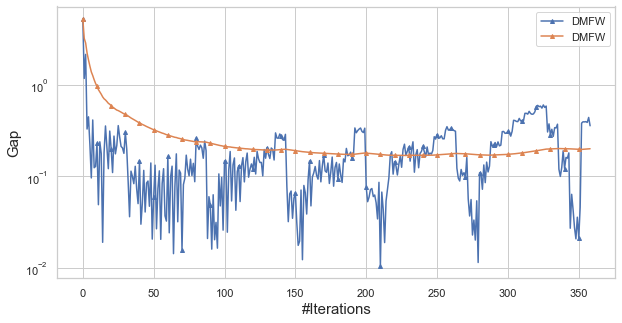

In [35]:
plt.figure(figsize=(10,5))
plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,2][:-1], label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,2][:-1]), label='DMFW', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

Text(0, 0.5, 'Loss')

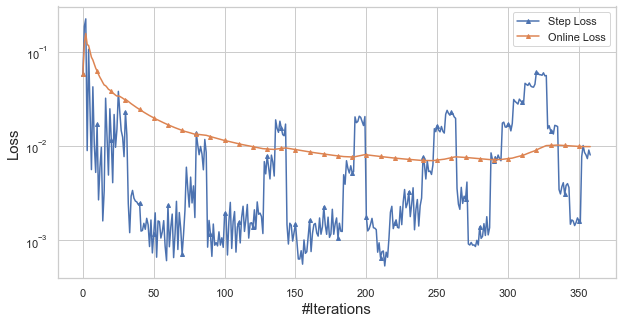

In [36]:
plt.figure(figsize=(10,5))
plt.plot(obj_val_ofw[:,0][:-1],obj_val_ofw[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.plot(obj_val_ofw[:,0][:-1],average_loss(obj_val_ofw[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val_ofw[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [108]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

In [109]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_
        mini = scalers[zone_name].data_min_
        data_range = 1
        #true = ((true.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #pred = ((pred.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        true = scalers[zone_name].inverse_transform(true.reshape(-1,1))
        pred = scalers[zone_name].inverse_transform(pred.reshape(-1,1))
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [111]:
def plotprediction(pandas): 
    plt.figure(figsize=(15,5))
    plt.title(f'{myfloor[indexroom]}')
    plt.plot(pandas["Truth"],label="Truth")
    plt.plot(pandas["Prediction"],label="Prediction",ls='-')
    plt.xticks(ticks=np.arange(pandas.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    plt.show()

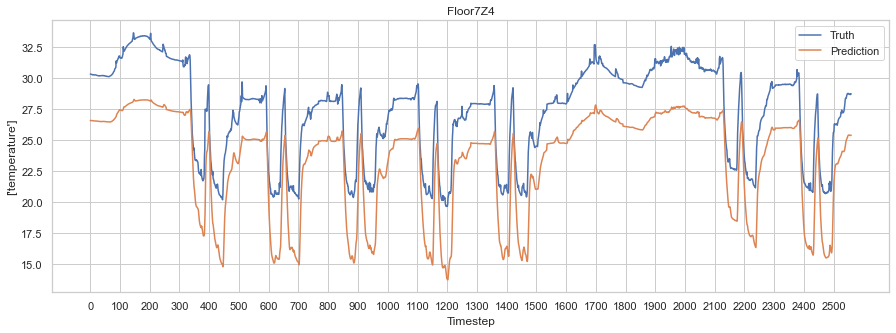

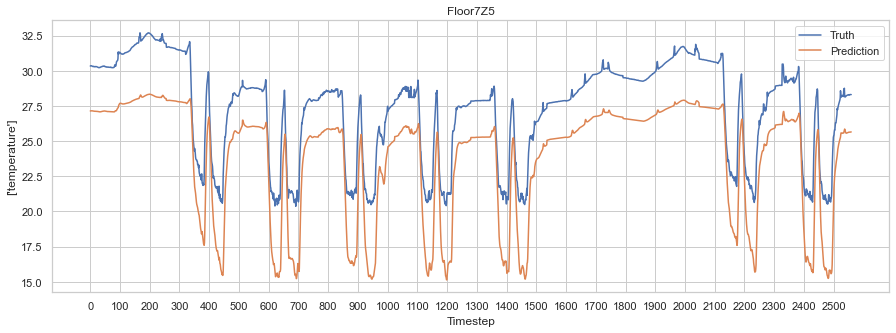

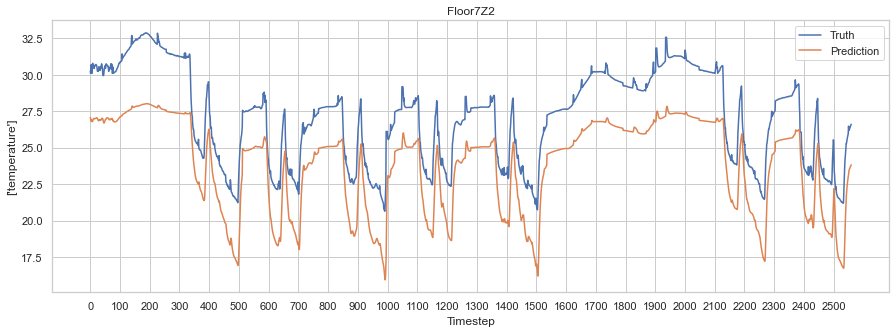

In [123]:
myfloor = zone_id#sorted(list(scaled_data.keys()))
may = [date for date in test_date if '2019-05' in date or "2019-04" in date]
for indexroom in range(len(trainloader)):
    mymodel = trainer.model_ofw
    resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[10],testloader[indexroom], lookahead, scalers,
                                     myfloor[indexroom])
    plotprediction(resultpd)
    #pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')